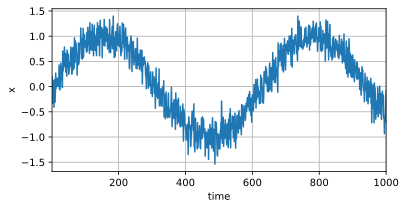

In [1]:
%matplotlib inline
from d2l import torch as d2l
import torch
import torch.nn as nn

T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [2]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = d2l.reshape(x[tau:], (-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [3]:
# Function for initializing the weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

# A simple MLP
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# Square loss
loss = nn.MSELoss()

In [4]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.069897
epoch 2, loss: 0.054346
epoch 3, loss: 0.050609
epoch 4, loss: 0.053958
epoch 5, loss: 0.050482


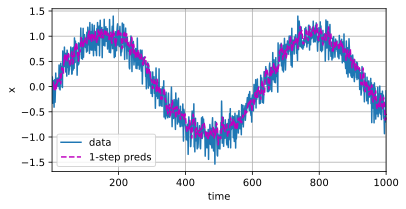

In [5]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [d2l.numpy(x), d2l.numpy(onestep_preds)], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

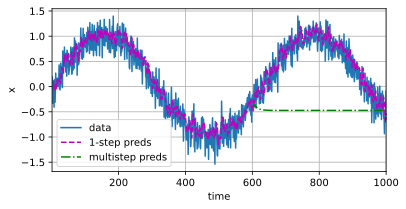

In [6]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = d2l.reshape(net(
        multistep_preds[i - tau:i].reshape(1, -1)), 1)

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [d2l.numpy(x), d2l.numpy(onestep_preds),
          d2l.numpy(multistep_preds[n_train + tau:])], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

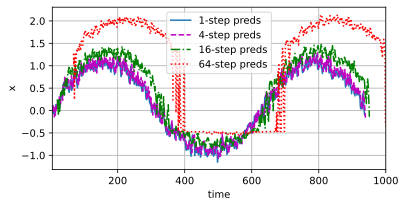

In [7]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1].T

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = d2l.reshape(net(features[:, i - tau:i]), -1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [d2l.numpy(features[:, tau + i - 1]) for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))